# Import Package

In [2]:
import math
import datetime
import numpy as np
import pandas as pd
from entropy import *
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
from scipy.interpolate import interp1d
import random
import joblib
import sklearn
from sklearn import metrics
import sklearn.model_selection
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn import svm
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier
from sklearn.pipeline import Pipeline
# from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import datetime
from sklearn.model_selection import ShuffleSplit
import scipy.io as sio 


/Users/fangaoyige/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Load Dataset

In [4]:
matfn = 'posture_5_data.mat'
data = sio.loadmat(matfn)  

trainSet   = data['x_train']
testSet    = data['x_test']
trainLabel = data['y_train']
testLabel  = data['y_test']

trainSet   = np.array(trainSet  )
testSet    = np.array(testSet   )

np.set_printoptions(threshold=np.inf)

trainSet = trainSet.reshape(trainSet.shape[0], 200, 16)
trainSet = trainSet[:,:,8:16]
trainSet = trainSet.reshape(trainSet.shape[0], 200*8)

testSet = testSet.reshape(testSet.shape[0], 200, 16)
testSet = testSet[:,:,8:16]
testSet = testSet.reshape(testSet.shape[0], 200*8)



print("trainSet", trainSet.shape)
print("testSet ", testSet.shape)


trainSet (1000, 1600)
testSet  (250, 1600)


In [5]:

trainLabel = np.array(trainLabel).ravel()
testLabel  = np.array(testLabel ).ravel()

className = ['no motion', 'sit & stand', 'walk', 'run', 'turn right']

# replace label with string
trainLabel = [className[i] for i in trainLabel]
testLabel  = [className[i] for i in testLabel ]


print("trainSet", trainSet.shape)
print("testSet ", testSet.shape)
# print("trainLabel", trainLabel.shape)
# print("testLabel ", testLabel.shape)


trainSet (1000, 1600)
testSet  (250, 1600)


# Random Forest

In [6]:

rf= RandomForestClassifier(random_state=0, n_estimators=1000, max_depth=5, n_jobs=4, class_weight="balanced")

starttime = datetime.datetime.now()
rf.fit(trainSet, trainLabel)
endtime = datetime.datetime.now()
rfResult = rf.predict(testSet)
# print(rfResult)
# save the model
joblib.dump(rf, "model/rf_model.m")

from sklearn.metrics import f1_score
print("F-score: {0:.2f}".format(f1_score(rfResult,testLabel,average='micro')))

print("the accurancy is :",np.mean(rfResult == testLabel))

print (endtime - starttime)

F-score: 0.93
the accurancy is : 0.932
0:00:05.049873


/Users/fangaoyige/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/ensemble/base.py:157: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


[0.         0.00485437 0.00512821 0.00970874 0.01538462 0.75384615
 0.76410256 0.9025641  0.90816327 0.92788462 0.9375     0.94660194
 0.95384615 0.95897436 0.96153846 0.96923077 0.97435897 0.98469388
 0.98974359 0.99029126 0.99038462 0.99487179 1.        ]


/Users/fangaoyige/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


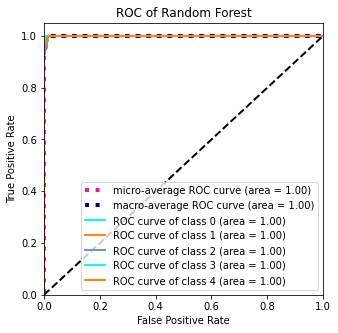

In [12]:
lw =2
proba = rf.predict_proba(testSet)
testLabel_bi = label_binarize(testLabel, classes=[0,1,2,3,4])
rfResult_bi = label_binarize(rfResult, classes=[0,1,2,3,4])


n_classes = 5

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    #print(testLabel[:, i])
    #print(proba[:, i])
    fpr[i], tpr[i], _ = roc_curve(testLabel_bi[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testLabel_bi.ravel(), proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#######


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
print(all_fpr)

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves


plt.figure(figsize=(5, 5))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Random Forest')
plt.legend(loc="lower right")
plt.savefig('figure/rf_roc.png')
plt.show()




# plot_learning_curve function

In [5]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    #ylim定义绘制的最小和最大y值
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="aquamarine")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="dodgerblue")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="aquamarine",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="dodgerblue",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.savefig('figure/'+title+'.png')
    return plt

# Learning Curve

<module 'matplotlib.pyplot' from '/Users/fangaoyige/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/pyplot.py'>

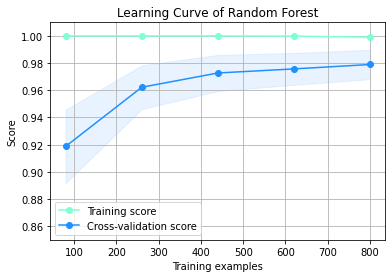

In [6]:
X = trainSet
y = trainLabel
# print(X.shape)
# print(y.shape)

title = "Learning Curve of Random Forest"
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
plot_learning_curve(rf, title, X, y, (0.85, 1.01), cv=cv, n_jobs=4)


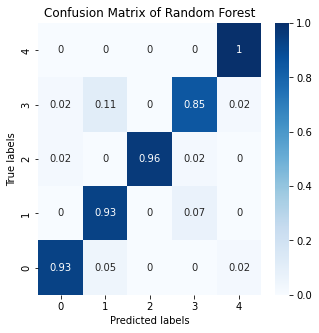

In [7]:
# 混淆矩阵
con_mat = confusion_matrix(testLabel, rfResult)

con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)

# === plot ===
plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')

plt.ylim(0, 5)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of Random Forest')
# save the figure
plt.savefig('figure/rf_confusion_matrix.png')
plt.show()


# LBGMClassifier

In [8]:
lgbm = LGBMClassifier(objective = 'multiclass', boosting_type = 'goss', num_leaves = 10, max_depth= -1, n_estimators =50, learning_rate = 0.3, subsample_for_bin = 800, n_jobs=4)
starttime = datetime.datetime.now()
lgbm.fit(trainSet, trainLabel)
endtime = datetime.datetime.now()
lgbmResult = lgbm.predict(testSet)

# save the model
joblib.dump(lgbm, 'model/lgbm.model')

from sklearn.metrics import f1_score
print("F-score: {0:.2f}".format(f1_score(lgbmResult,testLabel,average='micro')))
print("the accurancy is :",np.mean(lgbmResult == testLabel))

print (endtime - starttime)

F-score: 0.99
the accurancy is : 0.992
0:00:10.452495


[0.         0.00485437 0.00512821 1.        ]


/Users/fangaoyige/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


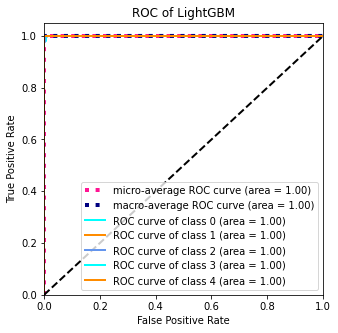

In [41]:
proba = lgbm.predict_proba(testSet)
testLabel_bi = label_binarize(testLabel, classes=[0 ,1, 2,3,4])
lgbmResult_bi = label_binarize(lgbmResult, classes=[0 ,1, 2,3,4])


n_classes = 5

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):

    fpr[i], tpr[i], _ = roc_curve(testLabel_bi[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testLabel_bi.ravel(), proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#######


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
print(all_fpr)

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves


plt.figure(figsize=(5, 5))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of LightGBM')
plt.legend(loc="lower right")
plt.savefig('figure/lgbm_roc.png')
plt.show()




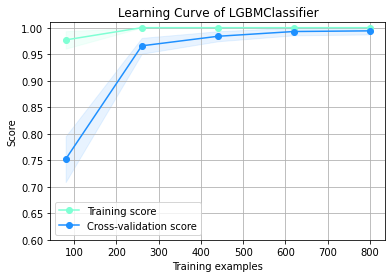

In [10]:
X = trainSet
y = trainLabel

title = "Learning Curve of LGBMClassifier"
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
plot_learning_curve(lgbm, title, X, y, (0.6, 1.01), cv=cv, n_jobs=4)
plt.show()

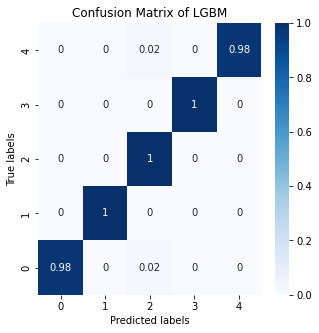

In [30]:
con_mat = confusion_matrix(testLabel, lgbmResult)

con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)

# === plot ===
plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')

plt.ylim(0, 5)
plt.title('Confusion Matrix of LGBM')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('figure/lgbm_confusion_matrix.png')
plt.show()


# xgbBoost

In [12]:
xgb = XGBClassifier(random_state=0,n_estimators=100,scale_pos_weight=10,learning_rate=0.1,max_depth=6,subsample=0.8,min_child_weight=10)
xgb.fit(trainSet, trainLabel)
xgbResult = xgb.predict(testSet)

# save the model
joblib.dump(xgb, 'model/xgb.model')


from sklearn.metrics import f1_score
print("F-score: {0:.2f}".format(f1_score(xgbResult,testLabel,average='micro')))
print("the accurancy is :",np.mean(xgbResult == testLabel))

/Users/fangaoyige/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:26:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F-score: 0.98
the accurancy is : 0.976


[0.         0.00480769 0.01025641 0.01538462 1.        ]


/Users/fangaoyige/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


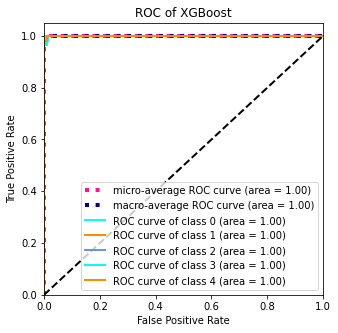

In [42]:
proba = xgb.predict_proba(testSet)
testLabel_bi = label_binarize(testLabel, classes=[0 ,1, 2,3,4])

n_classes = 5

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    #print(testLabel[:, i])
    #print(proba[:, i])
    fpr[i], tpr[i], _ = roc_curve(testLabel_bi[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testLabel_bi.ravel(), proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#######


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
print(all_fpr)

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves


plt.figure(figsize=(5, 5))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of XGBoost')
plt.legend(loc="lower right")
plt.savefig('figure/xgb_roc.png')
plt.show()




[15:27:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:27:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

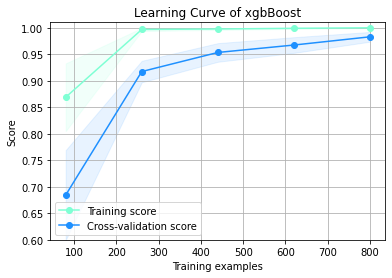

In [14]:
X = trainSet
y = trainLabel

title = "Learning Curve of xgbBoost"
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
plot_learning_curve(xgb, title, X, y, (0.6, 1.01), cv=cv, n_jobs=4)
plt.show()

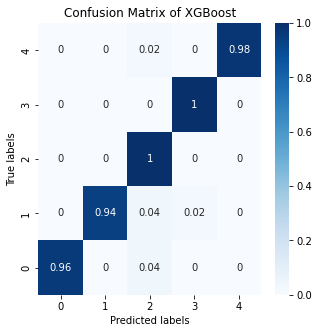

In [43]:
con_mat = confusion_matrix(testLabel, xgbResult)

con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)

# === plot ===
plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')

plt.ylim(0, 5)
plt.title('Confusion Matrix of XGBoost')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('figure/xgb_confusion_matrix.png')
plt.show()


# AdaBoost

In [16]:
ad=AdaBoostClassifier(DecisionTreeClassifier(),algorithm="SAMME.R", n_estimators=100,learning_rate=0.1,random_state=0)
ad.fit(trainSet, trainLabel)
adResult = ad.predict(testSet)

# save the model
joblib.dump(ad, 'model/ad.model')

from sklearn.metrics import f1_score
print("F-score: {0:.2f}".format(f1_score(adResult,testLabel,average='micro')))
print("the accurancy is :",np.mean(adResult == testLabel))

F-score: 0.89
the accurancy is : 0.888


[0.         0.01456311 0.02403846 0.03061224 0.03076923 0.04102564
 1.        ]


/Users/fangaoyige/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


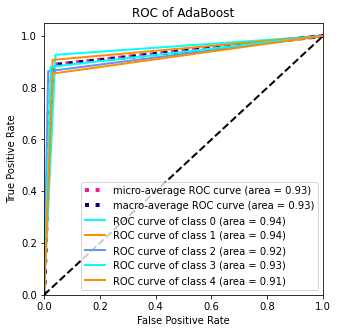

In [33]:
proba = ad.predict_proba(testSet)
testLabel_bi = label_binarize(testLabel, classes=[0,1,2,3,4])

n_classes = 5

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    #print(testLabel[:, i])
    #print(proba[:, i])
    fpr[i], tpr[i], _ = roc_curve(testLabel_bi[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testLabel_bi.ravel(), proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#######

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
print(all_fpr)

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves


plt.figure(figsize=(5, 5))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of AdaBoost')
plt.legend(loc="lower right")
plt.savefig('figure/ad_roc.png')  
plt.show()
  


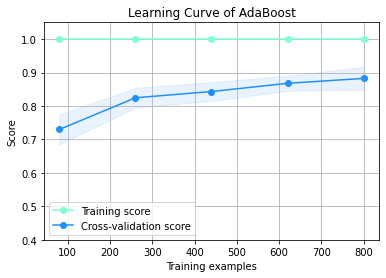

In [18]:
X = trainSet
y = trainLabel

title = "Learning Curve of AdaBoost"
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
plot_learning_curve(ad, title, X, y, (0.4, 1.05), cv=cv, n_jobs=4)
plt.show()

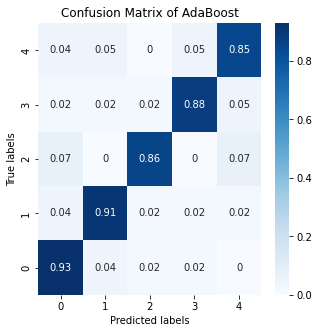

In [34]:
con_mat = confusion_matrix(testLabel, adResult)

con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)

# === plot ===
plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')

plt.ylim(0, 5)
plt.title('Confusion Matrix of AdaBoost')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('figure/ad_confusion_matrix.png')
plt.show()


# GBDT

In [20]:
gbdt = GradientBoostingClassifier(random_state=0,n_estimators=100,learning_rate=0.1,subsample=0.8)
starttime = datetime.datetime.now()
gbdt.fit(trainSet, trainLabel)
endtime = datetime.datetime.now()
gbdtResult = gbdt.predict(testSet)

# save the model
joblib.dump(gbdt,"model/gbdt_model.h5")

from sklearn.metrics import f1_score
print("F-score: {0:.3f}".format(f1_score(gbdtResult,testLabel,average='micro')))
print("the accurancy is :",np.mean(gbdtResult == testLabel))
print (endtime - starttime)

F-score: 0.980
the accurancy is : 0.98
0:03:08.590815


[0.         0.00485437 0.03589744 1.        ]


/Users/fangaoyige/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


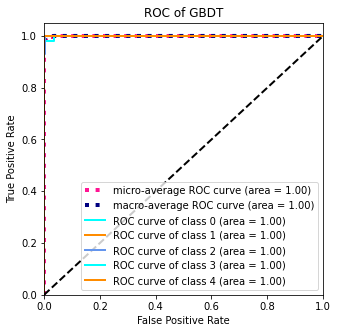

In [40]:
proba = gbdt.predict_proba(testSet)
testLabel_bi = label_binarize(testLabel, classes=[0 ,1, 2,3,4])

lw =2
n_classes = 5

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    #print(testLabel[:, i])
    #print(proba[:, i])
    fpr[i], tpr[i], _ = roc_curve(testLabel_bi[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testLabel_bi.ravel(), proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#######


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
print(all_fpr)

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves


plt.figure(figsize=(5, 5))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of GBDT')
plt.legend(loc="lower right")
plt.savefig('figure/gbdt_roc.png')
plt.show()








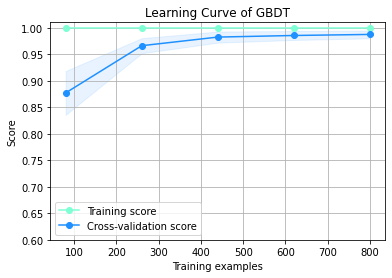

In [22]:
X = trainSet
y = trainLabel

title = "Learning Curve of GBDT"
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
plot_learning_curve(gbdt, title, X, y, (0.6, 1.01), cv=cv, n_jobs=4)
plt.show()

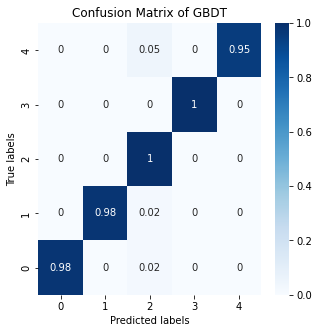

In [36]:
con_mat = confusion_matrix(testLabel, gbdtResult)

con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)

# === plot ===
plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')

plt.ylim(0, 5)
plt.title('Confusion Matrix of GBDT')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('figure/gbdt_confusion_matrix.png')
plt.show()


# SVM

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

svm = Pipeline(( ("scaler", StandardScaler()),
                     ("linear_svc", LinearSVC(C=1, loss="hinge")) ))
svm.fit(trainSet, trainLabel)
svmResult = svm.predict(testSet)
# save the model
joblib.dump(svm,"model/svm_model.h5")

from sklearn.metrics import f1_score
print("F-score: {0:.3f}".format(f1_score(svmResult,testLabel,average='micro')))
print("the accurancy is :",np.mean(svmResult == testLabel))


F-score: 0.780
the accurancy is : 0.78


/Users/fangaoyige/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


/Users/fangaoyige/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/fangaoyige/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


[0.         0.00510204 0.00512821 0.00961538 0.00970874 0.01025641
 0.01456311 0.01538462 0.02051282 0.02403846 0.02564103 0.03076923
 0.03365385 0.03398058 0.03589744 0.04102564 0.04326923 0.04807692
 0.05128205 0.05641026 0.06153846 0.06796117 0.07179487 0.07211538
 0.07281553 0.07692308 0.08252427 0.08737864 0.09223301 0.09230769
 0.09708738 0.10194175 0.10576923 0.10679612 0.10769231 0.11057692
 0.12820513 0.13592233 0.13846154 0.14563107 0.15384615 0.15533981
 0.15897436 0.16410256 0.16504854 0.17435897 0.17961165 0.18932039
 0.18974359 0.19902913 0.20512821 0.21359223 0.22564103 0.23300971
 0.24102564 0.25128205 0.27692308 0.28717949 0.2961165  0.30582524
 0.32820513 0.33009709 0.33980583 0.34951456 0.35897436 0.36407767
 0.4        0.41025641 0.50970874 0.5631068  0.60194175 0.66019417
 0.66504854 0.72815534 0.83163265 0.87692308 0.9368932  0.98461538
 1.        ]


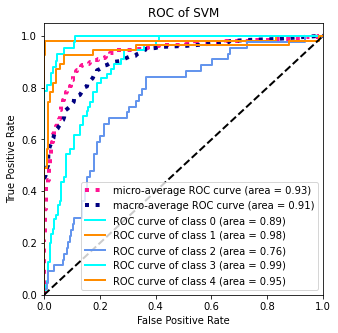

In [39]:
# proba = svm.predict_proba(testSet)
testLabel_bi = label_binarize(testLabel, classes=[0 ,1, 2,3,4])
y_score = svm.fit(trainSet, trainLabel).decision_function(testSet)

lw =2
n_classes = 5

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    #print(testLabel[:, i])
    #print(proba[:, i])
    fpr[i], tpr[i], _ = roc_curve(testLabel_bi[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testLabel_bi.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#######


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
print(all_fpr)

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves


plt.figure(figsize=(5, 5))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of SVM')
plt.legend(loc="lower right")
plt.savefig('figure/svm_roc.png')
plt.show()



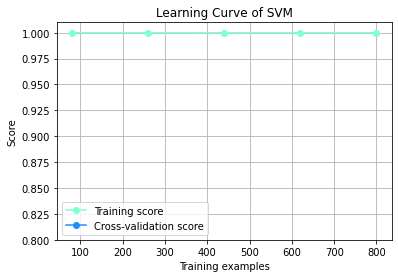

In [26]:
X = trainSet
y = trainLabel

title = "Learning Curve of SVM"
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
plot_learning_curve(svm, title, X, y, (0.80, 1.01), cv=cv, n_jobs=4)
plt.show()

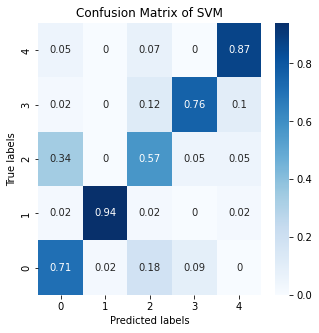

In [38]:
con_mat = confusion_matrix(testLabel, svmResult)

con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)

# === plot ===
plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')

plt.ylim(0, 5)
plt.title('Confusion Matrix of SVM')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
# save the figure
plt.savefig('figure/svm_confusion_matrix.png')
plt.show()
